In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from scipy.optimize import minimize

In [2]:
sns.set(rc={'figure.figsize':(10, 6)})

In [3]:
data = io.loadmat('data.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [5]:
def XTransform(X):
    return np.insert(X, 0, np.ones(X.shape[0]), axis = 1)

def yTransform(y):
    return y.flatten()

In [6]:
X_train = XTransform(data['X'])
y_train = yTransform(data['y'])

X_test = XTransform(data['Xtest'])
y_test = yTransform(data['ytest'])

X_val = XTransform(data['Xval'])
y_val = yTransform(data['yval'])

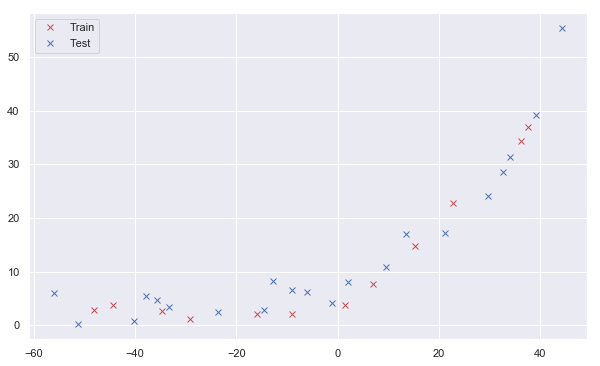

In [7]:
plt.plot(X_train[:,1], y_train, 'rx', label='Train')
plt.plot(X_test[:,1], y_test, 'bx', label='Test')
plt.legend(loc='best')
plt.show()

In [8]:
class LinearReg():
    def __init__(self):
        pass
    
    def LoadData(self, X, y):
        self.X = X
        self.y = y
        
    def Loss(self, W, X, y, l):
        m = X.shape[0]
        loss = sum((np.dot(X, W) - y)**2) + l*sum(W[1:]**2)
        return loss/(2*m)
        
    def Grad(self, W, X, y, l):
        m = X.shape[0]
        w = np.zeros(len(W))
        w[1:] = W[1:]
        grad = np.matmul(np.dot(X, W) - y, X) + l*w
        return grad/(m)
    
    def Fit(self, l):
        args_ = (self.X, self.y, l)
        W_init = np.random.rand(self.X.shape[1])
        res = minimize(fun=self.Loss, args=args_,
                      x0=W_init, method='TNC',
                      jac= self.Grad)
        self.W = res.x
        return res.x
    
    def Predict(self, X):
        return np.dot(X, self.W)

In [9]:
model = LinearReg()
model.LoadData(X_train, y_train)

In [10]:
lmbda = 0
b, a = model.Fit(lmbda)

In [11]:
x = X_train[:,1]
y = a * x + b

In [12]:
def PlotFitLine(xtrain, ytrain, xval, yval, lmbda, title):
    plt.plot(xtrain, ytrain, 'rx', label='Train')
    plt.plot(xval, yval, 'b--', label='Fit line')
    plt.legend(loc='best')
    plt.xlim((min(xval), max(xval)))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'{}, $\lambda$ = {}'.format(title, lmbda))
    plt.show()

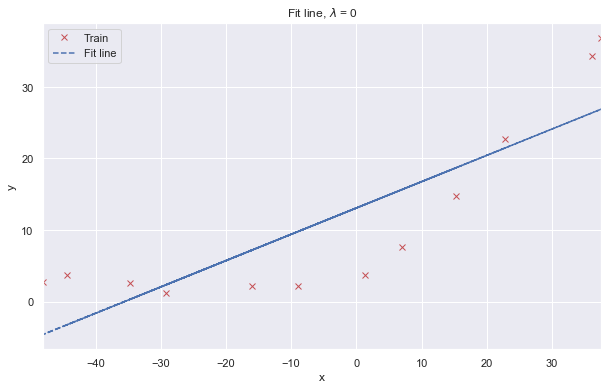

In [13]:
PlotFitLine(x, y_train, x, y, 0, "Fit line")

In [14]:
def ComputeLearningCurves(Xtr, ytr, Xval, yval, lmbda):
    train_loss = np.zeros(len(Xtr))
    val_loss = np.zeros(len(Xtr))

    for i in range(len(Xtr)):
        model = LinearReg()
        model.LoadData(Xtr[:i+1,:], ytr[:i+1])
        model.Fit(lmbda)
        train_loss[i] = model.Loss(model.W, 
                                     Xtr[:i+1,:], ytr[:i+1], 0)
        val_loss[i] = model.Loss(model.W, Xval, yval, 0)
    return train_loss, val_loss

In [15]:
def PlotLearningCurves(train_loss, val_loss, lmbda):
    x = range(len(train_loss))

    plt.plot(x, train_loss, 'r', label='Train')
    plt.plot(x, val_loss, 'b', label='Val')
    plt.title('Learning curves, $\lambda$ = {}'.format(lmbda))
    plt.xlim(1, max(x))
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.show()

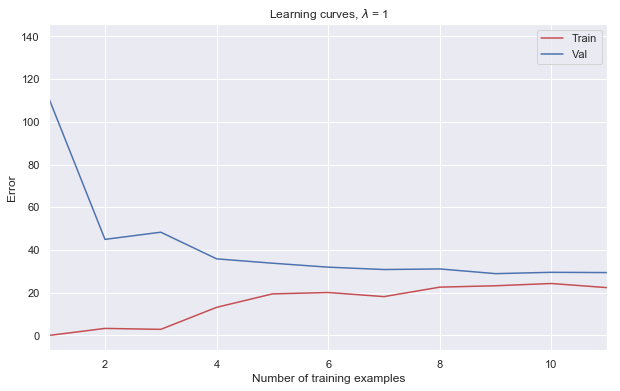

In [16]:
lmbda = 1
train_loss, val_loss = ComputeLearningCurves(X_train, y_train,
                                            X_val, y_val, lmbda)
PlotLearningCurves(train_loss, val_loss, lmbda)

In [17]:
def AddPolyFeatures(X, n):
    if n < 2:
        return X
    
    X = np.reshape(X, (len(X),1))
    for i in range(2,n+1):
        X = np.insert(X, i-1, X[:,0]**i, axis=1)
    return X

In [18]:
def Normalize(X, mean, std):
    X -= mean
    X /= std
    return X

In [19]:
p = 8

X_poly_train = AddPolyFeatures(X_train[:,1], p)
mean = np.mean(X_poly_train, axis=0)
std = np.std(X_poly_train, axis=0)
X_poly_train = XTransform(Normalize(X_poly_train, mean, std))

X_poly_test = AddPolyFeatures(X_test[:,1],p)
X_poly_test = XTransform(Normalize(X_poly_test, mean, std))

X_poly_val = AddPolyFeatures(X_val[:,1],p)
X_poly_val = XTransform(Normalize(X_poly_val, mean, std))

In [20]:
lmbda = 1
poly_model = LinearReg()
poly_model.LoadData(X_poly_train, y_train)
poly_model.Fit(lmbda)

array([11.21758934,  8.36719069,  5.10204089,  3.39013883,  2.15888231,
        1.62055581,  0.97241753,  1.02551735,  0.322479  ])

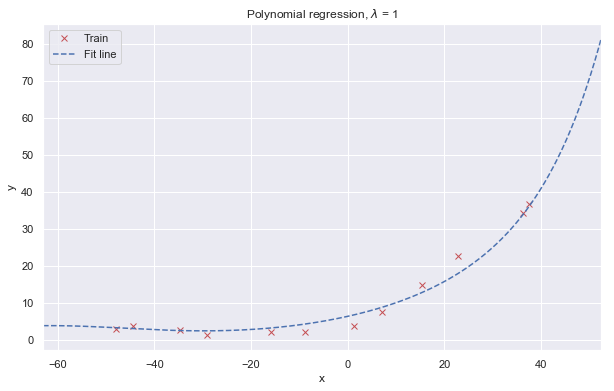

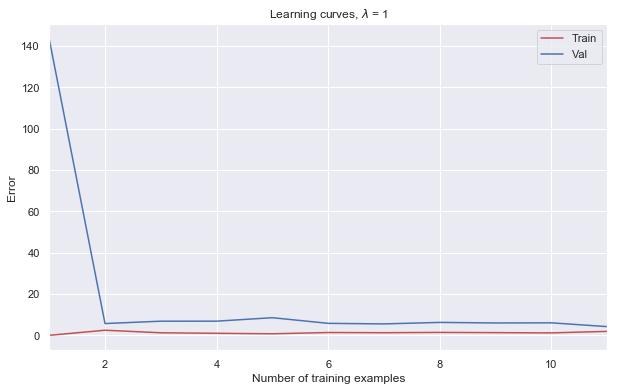

In [21]:
X_poly = np.arange(min(X_train[:,1])-15,max(X_train[:,1])+15,0.1)
y_poly = poly_model.Predict(XTransform(Normalize(AddPolyFeatures(X_poly, 8),
                                  mean, std)))

poly_train_loss, poly_val_loss = ComputeLearningCurves(X_poly_train, y_train,
                                                       X_poly_val, y_val, lmbda)

PlotFitLine(X_train[:,1], y_train, X_poly, y_poly, lmbda, 'Polynomial regression')
PlotLearningCurves(poly_train_loss, poly_val_loss, lmbda)

In [22]:
lmbda_list = [0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_loss_list = []
val_loss_list = []

model = LinearReg()
model.LoadData(X_poly_train, y_train)
for i in lmbda_list:
    weights = model.Fit(i)
    train_loss_list.append(model.Loss(weights, X_poly_train, y_train, 0))
    val_loss_list.append(model.Loss(weights, X_poly_val, y_val, 0))

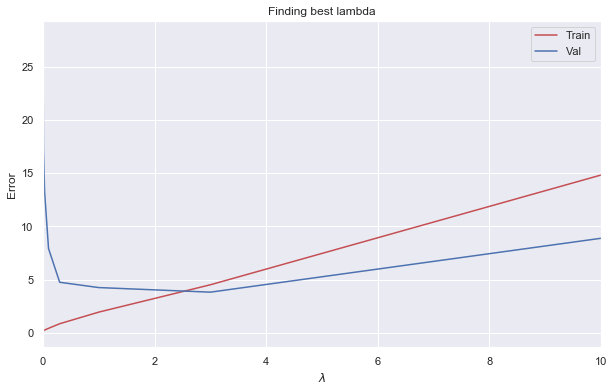

In [23]:
plt.plot(lmbda_list, train_loss_list, 'r', label = 'Train')
plt.plot(lmbda_list, val_loss_list, 'b', label = 'Val')
plt.title('Finding best lambda')
plt.xlabel('$\lambda$')
plt.xlim(0, max(lmbda_list))
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

In [24]:
lmbda = 3
model = LinearReg()
model.LoadData(X_poly_train, y_train)
model.Fit(lmbda)

array([11.2176166 ,  6.52207885,  3.82486864,  3.61985113,  2.18396141,
        2.10605805,  1.28086384,  1.28787595,  0.72485146])

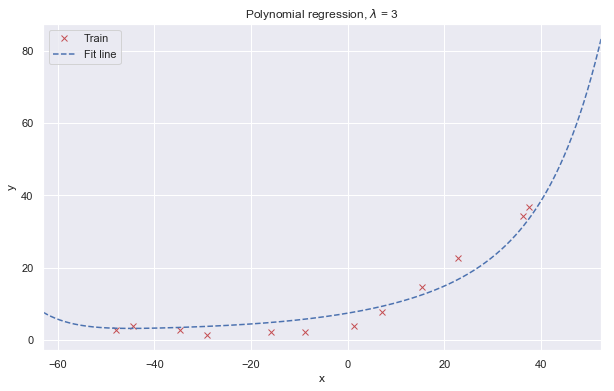

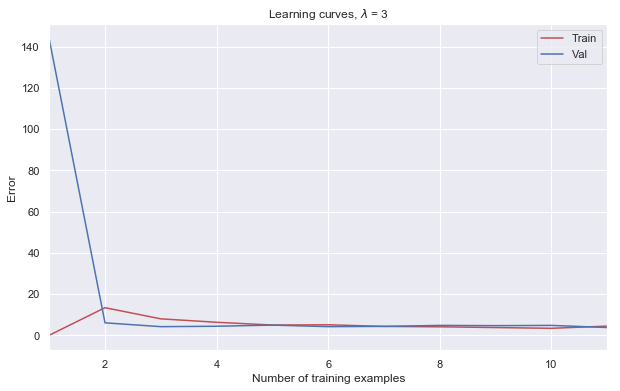

In [25]:
X_poly = np.arange(min(X_train[:,1])-15,max(X_train[:,1])+15,0.1)
y_poly = model.Predict(XTransform(Normalize(AddPolyFeatures(X_poly, 8),
                                  mean, std)))

poly_train_loss, poly_val_loss = ComputeLearningCurves(X_poly_train, y_train,
                                                       X_poly_val, y_val, lmbda)

PlotFitLine(X_train[:,1], y_train, X_poly, y_poly, lmbda, 'Polynomial regression')
PlotLearningCurves(poly_train_loss, poly_val_loss, lmbda)